# **Apply ML algorithms to saved features to create zone clusters**
* Segment taxi zones based on features and trip behavior.

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os, sys

In [51]:
df = pd.read_parquet('../data/artifacts/zone_features.parquet').dropna()

In [52]:
df.head()

,PULocationID,zone,borough,avg_trip_duration,avg_trip_distance,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips,avg_fare_amount,avg_trips_per_day
0,7,Astoria,Queens,20.078063,2.651375,0.261216,0.340810,0.086831,0.308249,16.339197,43.187500
1,19,Bellerose,Queens,17.277004,5.291139,0.265823,0.126582,0.215190,0.632911,22.933544,3.434783
2,22,Bensonhurst West,Brooklyn,50.571396,5.461757,0.162162,0.256757,0.500000,0.716216,41.226081,2.551724
3,26,Borough Park,Brooklyn,31.615530,5.788977,0.079545,0.125000,0.500000,0.659091,34.042045,3.259259
4,29,Brighton Beach,Brooklyn,51.256140,12.441842,0.065789,0.171053,0.736842,0.855263,53.957237,3.040000


In [53]:
df.shape

(253, 11)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PULocationID         253 non-null    int64  
 1   zone                 253 non-null    object 
 2   borough              253 non-null    object 
 3   avg_trip_duration    253 non-null    float64
 4   avg_trip_distance    253 non-null    float64
 5   pct_night_trips      253 non-null    float64
 6   pct_weekend_trips    253 non-null    float64
 7   pct_long_trips       253 non-null    float64
 8   pct_high_fare_trips  253 non-null    float64
 9   avg_fare_amount      253 non-null    float64
 10  avg_trips_per_day    253 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 21.9+ KB


In [55]:
df.describe()

,PULocationID,avg_trip_duration,avg_trip_distance,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips,avg_fare_amount,avg_trips_per_day
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,133.727273,24.596741,5.019214,0.220066,0.278459,0.280168,0.565072,29.647111,367.153077
std,76.652281,15.395535,2.995673,0.146261,0.139888,0.226962,0.262079,14.042286,885.757398
min,1.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,15.650492,2.839511,0.125380,0.203201,0.064877,0.368116,19.791801,2.230769
50%,136.000000,21.450000,4.336589,0.201493,0.256757,0.246154,0.600000,27.281538,5.419355
75%,200.000000,30.185256,5.903824,0.269231,0.327381,0.420118,0.772727,38.932085,54.516129
max,263.000000,186.700000,18.196429,0.833333,1.000000,1.000000,1.000000,87.988020,4698.612903


In [56]:
df.isna().sum()

PULocationID           0
zone                   0
borough                0
avg_trip_duration      0
avg_trip_distance      0
pct_night_trips        0
pct_weekend_trips      0
pct_long_trips         0
pct_high_fare_trips    0
avg_fare_amount        0
avg_trips_per_day      0
dtype: int64

In [57]:
id_cold = ['PULocationID', 'zone', 'borough']

In [58]:
features = [
    'avg_trip_distance',
    'avg_trip_duration',
    'avg_fare_amount',
    'avg_trips_per_day',
    'pct_night_trips',
    'pct_weekend_trips',
    'pct_long_trips',
    'pct_high_fare_trips'
]

In [59]:
scaler = StandardScaler()

In [60]:
X = df[features]

X_scaled = scaler.fit_transform(X)      # Kmeans uses distance. Features are on different scales.

**ELBOW METHOD**

In [61]:
inertia = []                # How far each point is from its assigned cluster center.

for k in range(2, 11):
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X_scaled)
    inertia.append(km.inertia_)

list(zip(range(2, 11), inertia) )

[(2, 1348.3593699534445),
 (3, 1131.339767211921),
 (4, 957.0039984993784),
 (5, 843.3651732542404),
 (6, 756.2641729778858),
 (7, 666.7070841223256),
 (8, 608.5176894146671),
 (9, 551.2024573025402),
 (10, 515.2348131807333)]

**At k=4, the inertia starts to decrease more slowly, indicating diminishing returns for increasing k further.**

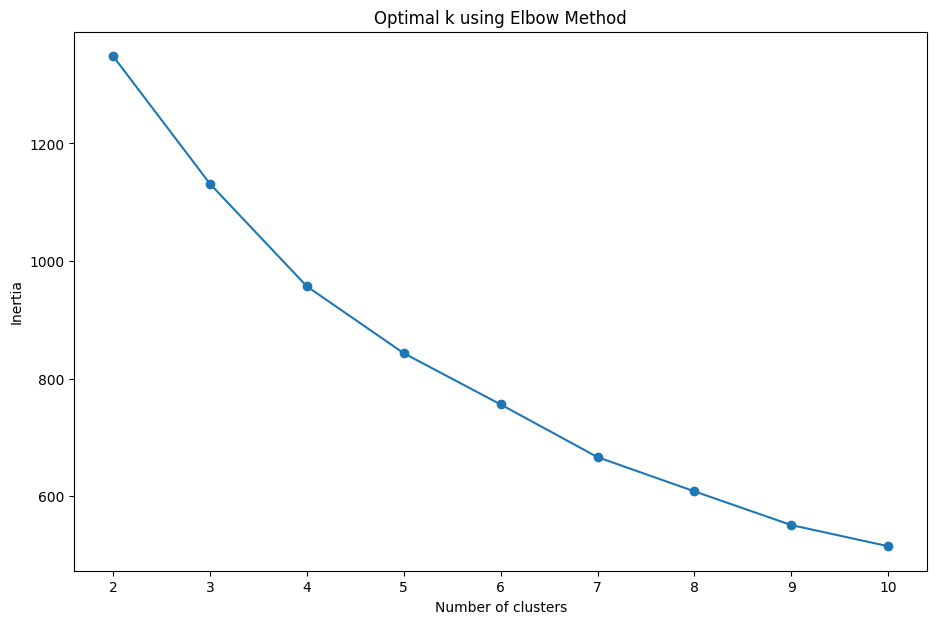

In [62]:
plt.figure(figsize=(11, 7))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Optimal k using Elbow Method')
plt.show()

**Silhoutte Score**

In [63]:
for i in range(2, 11):
    km = KMeans(
        n_clusters=i,
        random_state=42,
        n_init=10
    )
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={i}, silhouette={score:.3f}")

k=2, silhouette=0.318
k=3, silhouette=0.262
k=4, silhouette=0.287
k=5, silhouette=0.272
k=6, silhouette=0.246
k=7, silhouette=0.276
k=8, silhouette=0.284
k=9, silhouette=0.261
k=10, silhouette=0.257


**Still k!=2 because it means : taxi zones fall into only TWO types.**
* High-demand zones
* Everything else

**Selected k=4 to balance cluster separation with interpretability and to capture distinct urban mobility patterns.**

In [64]:
kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)
df['cluster_id'] = kmeans.fit_predict(X_scaled)

In [65]:
df['cluster_id'].value_counts().sort_index()        # cluster_id are the clusters to which each zone belongs to.

cluster_id
0    113
1     53
2     49
3     38
Name: count, dtype: int64

In [66]:
cluster_summary = df.groupby('cluster_id')[features].mean().round(2)
cluster_summary

,avg_trip_distance,avg_trip_duration,avg_fare_amount,avg_trips_per_day,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips
cluster_id,,,,,,,,
0,4.53,25.02,30.46,20.85,0.18,0.23,0.30,0.65
1,9.32,40.22,46.77,151.25,0.19,0.23,0.58,0.86
2,2.46,12.78,14.05,1534.28,0.20,0.26,0.04,0.17
3,3.77,16.79,23.45,193.10,0.42,0.50,0.13,0.42


In [67]:
df.sort_values('avg_trips_per_day', ascending=False).head(10)

,PULocationID,zone,borough,avg_trip_duration,avg_trip_distance,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips,avg_fare_amount,avg_trips_per_day,cluster_id
23,237,Upper East Side South,Manhattan,11.732640,1.786139,0.123674,0.217882,0.022800,0.098828,12.197784,4698.612903,2
133,132,JFK Airport,Queens,36.471856,15.085444,0.274799,0.296408,0.631296,0.912430,58.624030,4564.171429,1
84,236,Upper East Side North,Manhattan,12.459275,1.950519,0.073317,0.218983,0.028316,0.127257,12.979710,4359.741935,2
55,161,Midtown Center,Manhattan,14.497095,2.361893,0.159537,0.201485,0.042967,0.149085,15.053972,4171.062500,2
166,186,Penn Station/Madison Sq West,Manhattan,15.540334,2.299782,0.188343,0.261537,0.052965,0.196074,15.354929,3383.125000,2
172,162,Midtown East,Manhattan,13.990422,2.336532,0.150143,0.203201,0.035987,0.148094,14.718467,3249.406250,2
121,142,Lincoln Square East,Manhattan,12.589000,2.310665,0.224247,0.286974,0.030966,0.117706,13.440907,3064.843750,2
182,230,Times Sq/Theatre District,Manhattan,15.589676,2.953553,0.277183,0.281531,0.071103,0.212848,17.145303,3047.062500,2
80,170,Murray Hill,Manhattan,13.442134,2.293693,0.165395,0.243736,0.035604,0.151777,14.667962,2795.064516,2
104,138,LaGuardia Airport,Queens,26.614916,9.655717,0.222754,0.242073,0.290512,0.939454,40.889850,2693.151515,1


In [68]:
df[df['cluster_id'] == 2][['zone', 'borough', 'avg_fare_amount', 'avg_trips_per_day']].sort_values('avg_trips_per_day', ascending=False).head(10)

,zone,borough,avg_fare_amount,avg_trips_per_day
23,Upper East Side South,Manhattan,12.197784,4698.612903
84,Upper East Side North,Manhattan,12.979710,4359.741935
55,Midtown Center,Manhattan,15.053972,4171.062500
166,Penn Station/Madison Sq West,Manhattan,15.354929,3383.125000
172,Midtown East,Manhattan,14.718467,3249.406250
121,Lincoln Square East,Manhattan,13.440907,3064.843750
182,Times Sq/Theatre District,Manhattan,17.145303,3047.062500
80,Murray Hill,Manhattan,14.667962,2795.064516
77,Upper West Side South,Manhattan,13.396696,2630.593750
181,Midtown North,Manhattan,14.919989,2622.906250


In [69]:
df.groupby("cluster_id")[[
    "avg_trips_per_day",
    "avg_trip_duration",
    "avg_trip_distance",
    "avg_fare_amount",
    "pct_night_trips",
    "pct_weekend_trips"
]].mean()

,avg_trips_per_day,avg_trip_duration,avg_trip_distance,avg_fare_amount,pct_night_trips,pct_weekend_trips
cluster_id,,,,,,
0,20.846646,25.020734,4.531136,30.463971,0.176392,0.230448
1,151.253110,40.215811,9.322812,46.770987,0.194993,0.233189
2,1534.282977,12.777876,2.457992,14.045942,0.196358,0.263332
3,193.099387,16.791544,3.770850,23.452019,0.415479,0.503875


In [70]:
df.head(10)

,PULocationID,zone,borough,avg_trip_duration,avg_trip_distance,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips,avg_fare_amount,avg_trips_per_day,cluster_id
0,7,Astoria,Queens,20.078063,2.651375,0.261216,0.340810,0.086831,0.308249,16.339197,43.187500,3
1,19,Bellerose,Queens,17.277004,5.291139,0.265823,0.126582,0.215190,0.632911,22.933544,3.434783,0
2,22,Bensonhurst West,Brooklyn,50.571396,5.461757,0.162162,0.256757,0.500000,0.716216,41.226081,2.551724,1
3,26,Borough Park,Brooklyn,31.615530,5.788977,0.079545,0.125000,0.500000,0.659091,34.042045,3.259259,0
4,29,Brighton Beach,Brooklyn,51.256140,12.441842,0.065789,0.171053,0.736842,0.855263,53.957237,3.040000,1
5,34,Brooklyn Navy Yard,Brooklyn,21.910256,5.131154,0.076923,0.192308,0.230769,0.653846,26.007692,1.529412,0
6,54,Columbia Street,Brooklyn,14.157692,5.356538,0.307692,0.269231,0.115385,0.576923,31.665385,1.368421,0
7,65,Downtown Brooklyn/MetroTech,Brooklyn,20.803621,4.475270,0.184303,0.302733,0.131044,0.482831,23.626643,46.032258,0
8,77,East New York/Pennsylvania Avenue,Brooklyn,35.866912,4.961618,0.117647,0.176471,0.617647,0.779412,34.480882,2.518519,0
9,112,Greenpoint,Brooklyn,13.516818,3.283977,0.643182,0.600000,0.047727,0.518182,22.541045,14.193548,3


In [71]:
df.to_parquet('../data/artifacts/zone_clusters.parquet')